In [97]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd

In [61]:
rng = np.random.default_rng(9)

# Simulation

In [96]:
import SDP_interaction_inference.simulation

In [87]:
def simulate_dataframe(interaction_values, gene_values, runs, rate, cells):
    '''
    Simulate grid dataset
    '''

    # number of pairs
    gene_pairs = len(interaction_values) * len(gene_values) * runs

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # sample counter
    i = 0

    # for each sample
    for int_val in tqdm.tqdm(interaction_values):
        for gene_val in gene_values:
            for k in range(runs):

                # Set reaction rate parameters
                k_on_1 = gene_val
                k_on_2 = gene_val
                k_off_1 = 1 - gene_val
                k_off_2 = 1 - gene_val
                k_tx_1 = rate
                k_tx_2 = rate
                k_deg_1 = 1
                k_deg_2 = 1
                k_reg = int_val

                # store parameters
                params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

                params = {
                    'k_on_1': k_on_1,
                    'k_on_2': k_on_2,
                    'k_off_1': k_off_1,
                    'k_off_2': k_off_2,
                    'k_tx_1': k_tx_1,
                    'k_tx_2': k_tx_2,
                    'k_deg_1': k_deg_1,
                    'k_deg_2': k_deg_2,
                    'k_reg': k_reg
                }

                # simulate sample from model
                sample = SDP_interaction_inference.simulation.gillespie_telegraph(params, cells)

                # store counts
                counts_df.iloc[i] = sample

                # increment sample
                i += 1

    return counts_df, params_df

In [88]:
def downsample_dataframe(counts_df, mean_capture):

    # dataframe size
    gene_pairs, cells = counts_df.shape

    # beta parameter
    b = (1 / mean_capture) - 1

    # capture vector
    if b == 0:
        beta = np.ones(cells)
    else:
        beta = rng.beta(1, b, size=cells)

    # setup downsampled dataset
    downsampled_counts_df = pd.DataFrame(
        index=[f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns=[f"Cell-{j}" for j in range(cells)]
    )

    # for each sample
    for i in range(gene_pairs):

        # extract counts
        sample = counts_df.iloc[i]
        x1_sample = [x[0] for x in sample]
        x2_sample = [x[1] for x in sample]

        # downsample
        x1_sample_downsampled = rng.binomial(x1_sample, beta).tolist()
        x2_sample_downsampled = rng.binomial(x2_sample, beta).tolist()
        sample_downsampled = list(zip(x1_sample_downsampled, x2_sample_downsampled))
        
        # store counts
        downsampled_counts_df.iloc[i] = sample_downsampled

    return downsampled_counts_df, beta

## Running

In [95]:
# parameter settings
interaction_values = [0.0, 0.1, 0.2, 0.5, 0.75, 1.0, 2.0, 10.0]
gene_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.2]
rate = 5
runs = 3
cells = 1000

In [ ]:
# simulate grid data
counts_df, params_df = simulate_dataframe(interaction_values, gene_values, runs, rate, cells)

# save to file
counts_df.to_csv(".\gridtest-data\counts_df.csv")
params_df.to_csv(".\gridtest-data\params_df.csv")

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [10:07<00:00, 75.99s/it]


In [94]:
# downsample data
downsampled_counts_50_df, beta_50 = downsample_dataframe(counts_df, 0.5)
downsampled_counts_10_df, beta_10 = downsample_dataframe(counts_df, 0.1)

# save to file
downsampled_counts_50_df.to_csv(".\gridtest-data\counts_50_df.csv")
downsampled_counts_10_df.to_csv(".\gridtest-data\counts_10_df.csv")
np.save(".\gridtest-data\\beta_50.npy", beta_50)
np.save(".\gridtest-data\\beta_10.npy", beta_10)

# Construct Dataset

In [100]:
import SDP_interaction_inference.dataset
import interaction_inference.dataset

In [102]:
dataset = SDP_interaction_inference.dataset.Dataset()
beta = np.load(".\gridtest-data\\beta_50.npy")
dataset.load_dataset(
    ".\gridtest-data\counts_50_df.csv",
    beta,
    ".\gridtest-data\params_df.csv"
)

In [109]:
dataset = interaction_inference.dataset.Dataset("test")
beta = np.load(".\gridtest-data\\beta_50.npy")
dataset.load_dataset(
    ".\gridtest-data\counts_50_df.csv",
    beta,
    ".\gridtest-data\params_df.csv"
)

# Results

In [113]:
from matplotlib.colors import LinearSegmentedColormap

In [116]:
def construct_result_array(analysis, interaction_values, gene_values, runs, correlation=False):
        
    # shape
    shape = (len(interaction_values), len(gene_values))

    # array for result objects
    result_array = np.zeros(shape)

    # sample counter
    i = 0

    # for each sample
    for j, _ in enumerate(interaction_values):
        for k, _ in enumerate(gene_values):
            for l in range(runs):

                # get result
                if correlation:

                    if analysis.result_dict[i]['pvalue'] < 0.05:
                        result_array[j, k] += 1 / runs

                else:

                    if analysis.result_dict[i]['status'] == "INFEASIBLE":
                        result_array[j, k] += 1 / runs

                # increment counter
                i += 1

    return result_array

In [114]:
def plot(result_array, interaction_values, gene_values, title, caption, figsize=(6, 6)):

    fig, axs = plt.subplots(figsize=figsize)

    cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)

    vmin, vmax = 0, 1

    img = axs.imshow(result_array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_xlabel(r"Gene on rate $k_{on}$ ($k_{off} = 1 - k_{on}$)")
    axs.set_xticks(range(len(gene_values)))
    axs.set_xticklabels(gene_values)
    axs.set_ylabel(r"Interaction strength $k_{reg}$")
    axs.set_yticks(range(len(interaction_values)))
    axs.set_yticklabels(interaction_values)
    axs.set_title(title)

    cbar = plt.colorbar(img, ax=axs)
    cbar.set_label(caption)

# Model free

In [110]:
data_100 = SDP_interaction_inference.dataset.Dataset()
beta = np.ones(cells)
data_100.load_dataset(
    ".\gridtest-data\counts_df.csv",
    beta,
    ".\gridtest-data\params_df.csv"
)

In [111]:
data_50 = SDP_interaction_inference.dataset.Dataset()
beta_50 = np.load(".\gridtest-data\\beta_50.npy")
data_50.load_dataset(
    ".\gridtest-data\counts_50_df.csv",
    beta_50,
    ".\gridtest-data\params_df.csv"
)

In [112]:
data_10 = SDP_interaction_inference.dataset.Dataset()
beta_10 = np.load(".\gridtest-data\\beta_10.npy")
data_10.load_dataset(
    ".\gridtest-data\counts_10_df.csv",
    beta_10,
    ".\gridtest-data\params_df.csv"
)

## Correlation

### Running

In [117]:
from SDP_interaction_inference.correlation import Correlation

In [ ]:
corr_100 = Correlation(data_100, printing=False)
corr_100_result = construct_result_array(corr_100, interaction_values, gene_values, runs, correlation=True)
np.save(".\gridtest-results\model-free\correlation\corr_100.npy", corr_100_result)

100%|██████████| 192/192 [00:02<00:00, 78.02it/s]


In [ ]:
corr_50 = Correlation(data_50, printing=False)
corr_50_result = construct_result_array(corr_50, interaction_values, gene_values, runs, correlation=True)
np.save(".\gridtest-results\model-free\correlation\corr_50.npy", corr_50_result)

100%|██████████| 192/192 [00:01<00:00, 100.72it/s]


In [ ]:
corr_10 = Correlation(data_10, printing=False)
corr_10_result = construct_result_array(corr_10, interaction_values, gene_values, runs, correlation=True)
np.save(".\gridtest-results\model-free\correlation\corr_10.npy", corr_10_result)

100%|██████████| 192/192 [00:02<00:00, 92.84it/s] 


### Plots

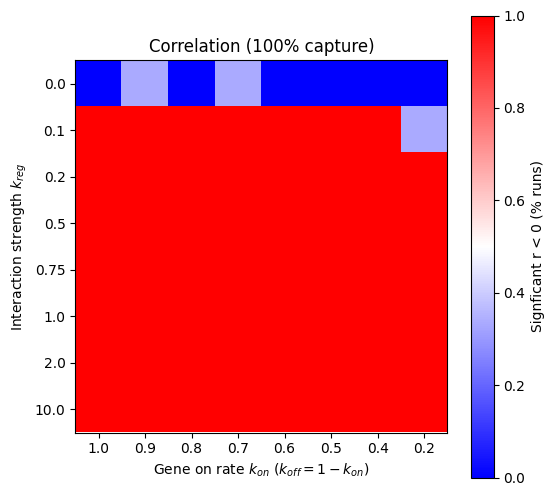

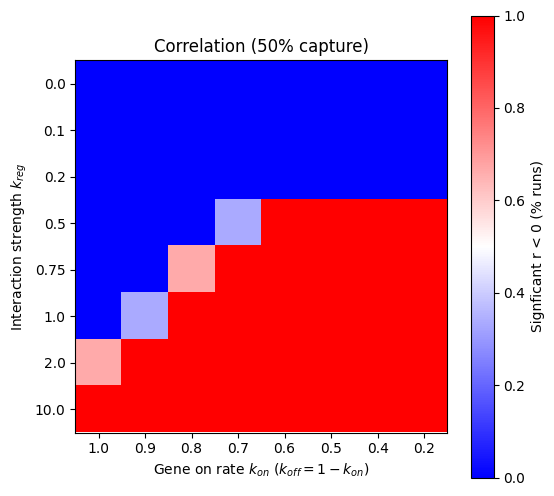

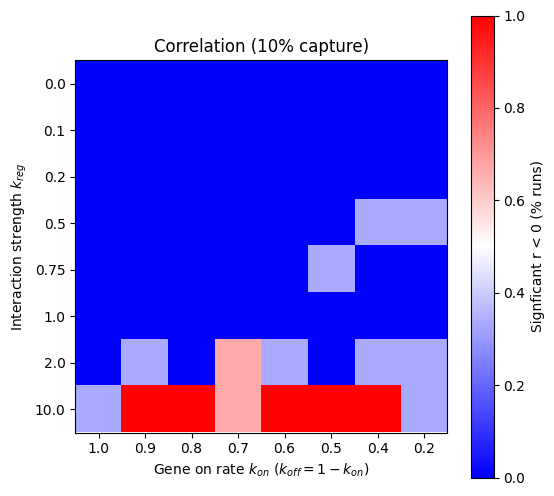

In [ ]:
# 100% capture
corr_100_result = np.load(".\gridtest-results\model-free\correlation\corr_100.npy")
plot(corr_100_result, interaction_values, gene_values, "Correlation (100% capture)", "Signficant r < 0 (% runs)")

# 50% capture
corr_50_result = np.load(".\gridtest-results\model-free\correlation\corr_50.npy")
plot(corr_50_result, interaction_values, gene_values, "Correlation (50% capture)", "Signficant r < 0 (% runs)")

# 10% capture
corr_10_result = np.load(".\gridtest-results\model-free\correlation\corr_10.npy")
plot(corr_10_result, interaction_values, gene_values, "Correlation (10% capture)", "Signficant r < 0 (% runs)")

## SDP Moments

### Running

In [126]:
import SDP_interaction_inference.optimization 

In [128]:
d_max = 10
data_100.bootstrap(d_max, tqdm_disable=False)
data_50.bootstrap(d_max, tqdm_disable=False)
data_10.bootstrap(d_max, tqdm_disable=False)

100%|██████████| 192/192 [01:49<00:00,  1.76it/s]


100% capture

In [130]:
sdp_100_d2 = SDP_interaction_inference.optimization.ModelFreeOptimization(data_100, d=2)
sdp_100_d2.analyse_dataset()
sdp_100_d2_result = construct_result_array(sdp_100_d2, interaction_values, gene_values, runs)
np.save(".\gridtest-results\model-free\sdp\sdp_100_d2.npy", sdp_100_d2_result)

100%|██████████| 192/192 [00:04<00:00, 42.53it/s]


In [136]:
sdp_100_d4 = SDP_interaction_inference.optimization.ModelFreeOptimization(data_100, d=4)
sdp_100_d4.analyse_dataset()
sdp_100_d4_result = construct_result_array(sdp_100_d4, interaction_values, gene_values, runs)
np.save(".\gridtest-results\model-free\sdp\sdp_100_d4.npy", sdp_100_d4_result)

100%|██████████| 192/192 [00:10<00:00, 18.38it/s]


In [133]:
sdp_100_d6 = SDP_interaction_inference.optimization.ModelFreeOptimization(data_100, d=6)
sdp_100_d6.analyse_dataset()
sdp_100_d6_result = construct_result_array(sdp_100_d6, interaction_values, gene_values, runs)
np.save(".\gridtest-results\model-free\sdp\sdp_100_d6.npy", sdp_100_d6_result)

100%|██████████| 192/192 [00:21<00:00,  8.79it/s]


50% capture

In [138]:
sdp_50_d2 = SDP_interaction_inference.optimization.ModelFreeOptimization(data_50, d=2)
sdp_50_d2.analyse_dataset()
sdp_50_d2_result = construct_result_array(sdp_50_d2, interaction_values, gene_values, runs)
np.save(".\gridtest-results\model-free\sdp\sdp_50_d2.npy", sdp_50_d2_result)

100%|██████████| 192/192 [00:03<00:00, 49.60it/s]


In [139]:
sdp_50_d4 = SDP_interaction_inference.optimization.ModelFreeOptimization(data_50, d=4)
sdp_50_d4.analyse_dataset()
sdp_50_d4_result = construct_result_array(sdp_50_d4, interaction_values, gene_values, runs)
np.save(".\gridtest-results\model-free\sdp\sdp_50_d4.npy", sdp_50_d4_result)

100%|██████████| 192/192 [00:11<00:00, 17.44it/s]


In [140]:
sdp_50_d6 = SDP_interaction_inference.optimization.ModelFreeOptimization(data_50, d=6)
sdp_50_d6.analyse_dataset()
sdp_50_d6_result = construct_result_array(sdp_50_d6, interaction_values, gene_values, runs)
np.save(".\gridtest-results\model-free\sdp\sdp_50_d6.npy", sdp_50_d6_result)

100%|██████████| 192/192 [00:22<00:00,  8.45it/s]


10% capture

In [141]:
sdp_10_d2 = SDP_interaction_inference.optimization.ModelFreeOptimization(data_10, d=2)
sdp_10_d2.analyse_dataset()
sdp_10_d2_result = construct_result_array(sdp_10_d2, interaction_values, gene_values, runs)
np.save(".\gridtest-results\model-free\sdp\sdp_10_d2.npy", sdp_10_d2_result)

100%|██████████| 192/192 [00:03<00:00, 50.09it/s]


In [142]:
sdp_10_d4 = SDP_interaction_inference.optimization.ModelFreeOptimization(data_10, d=4)
sdp_10_d4.analyse_dataset()
sdp_10_d4_result = construct_result_array(sdp_10_d4, interaction_values, gene_values, runs)
np.save(".\gridtest-results\model-free\sdp\sdp_10_d4.npy", sdp_10_d4_result)

100%|██████████| 192/192 [00:09<00:00, 19.72it/s]


In [143]:
sdp_10_d6 = SDP_interaction_inference.optimization.ModelFreeOptimization(data_10, d=6)
sdp_10_d6.analyse_dataset()
sdp_10_d6_result = construct_result_array(sdp_10_d6, interaction_values, gene_values, runs)
np.save(".\gridtest-results\model-free\sdp\sdp_10_d6.npy", sdp_10_d6_result)

100%|██████████| 192/192 [01:11<00:00,  2.67it/s]


### Plots

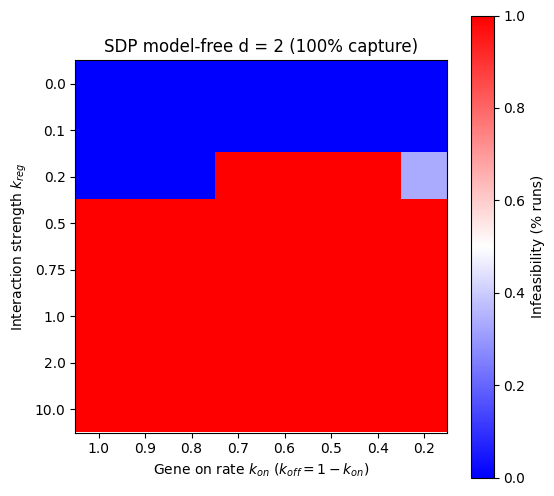

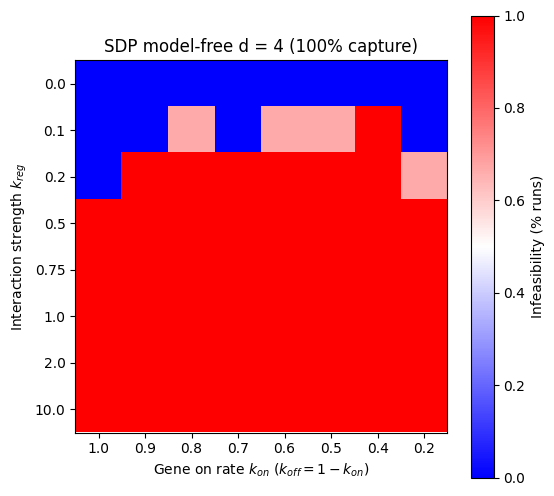

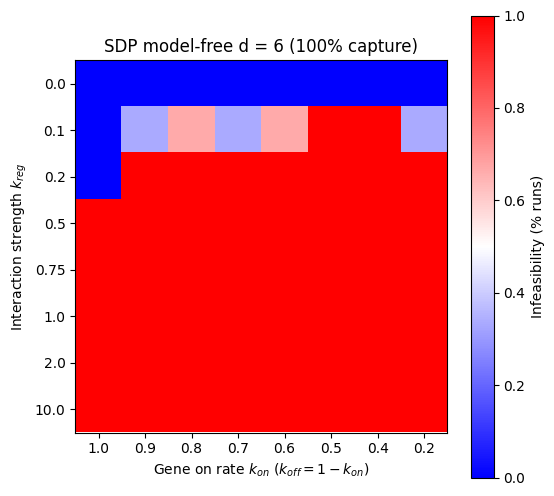

In [137]:
# 100% capture

# d = 2
sdp_100_d2_result = np.load(".\gridtest-results\model-free\sdp\sdp_100_d2.npy")
plot(sdp_100_d2_result, interaction_values, gene_values, "SDP model-free d = 2 (100% capture)", "Infeasibility (% runs)")

# d = 4
sdp_100_d4_result = np.load(".\gridtest-results\model-free\sdp\sdp_100_d4.npy")
plot(sdp_100_d4_result, interaction_values, gene_values, "SDP model-free d = 4 (100% capture)", "Infeasibility (% runs)")

# d = 6
sdp_100_d6_result = np.load(".\gridtest-results\model-free\sdp\sdp_100_d6.npy")
plot(sdp_100_d6_result, interaction_values, gene_values, "SDP model-free d = 6 (100% capture)", "Infeasibility (% runs)")

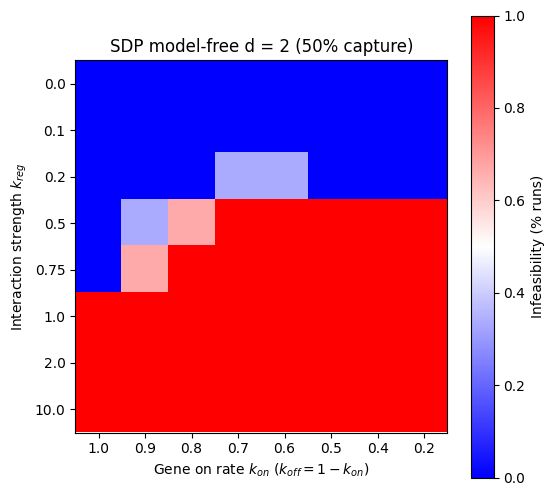

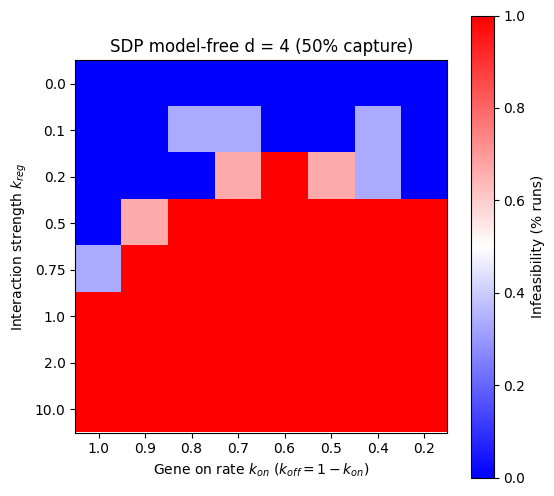

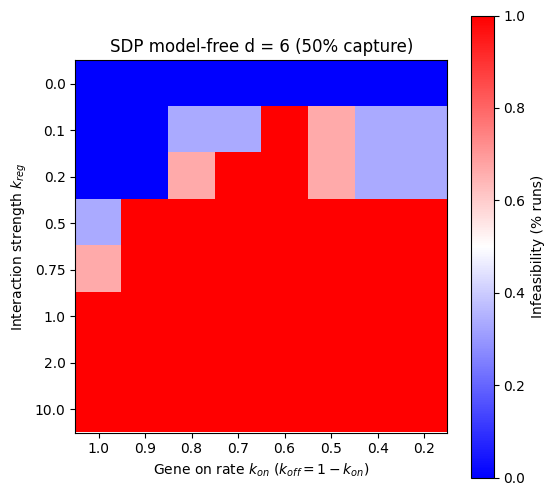

In [144]:
# 50% capture

# d = 2
sdp_50_d2_result = np.load(".\gridtest-results\model-free\sdp\sdp_50_d2.npy")
plot(sdp_50_d2_result, interaction_values, gene_values, "SDP model-free d = 2 (50% capture)", "Infeasibility (% runs)")

# d = 4
sdp_50_d4_result = np.load(".\gridtest-results\model-free\sdp\sdp_50_d4.npy")
plot(sdp_50_d4_result, interaction_values, gene_values, "SDP model-free d = 4 (50% capture)", "Infeasibility (% runs)")

# d = 6
sdp_50_d6_result = np.load(".\gridtest-results\model-free\sdp\sdp_50_d6.npy")
plot(sdp_50_d6_result, interaction_values, gene_values, "SDP model-free d = 6 (50% capture)", "Infeasibility (% runs)")

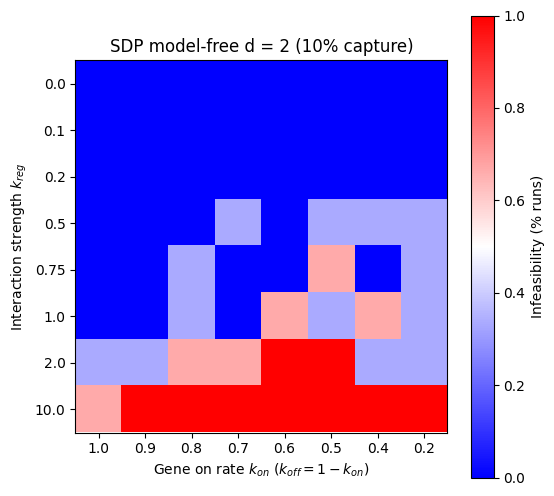

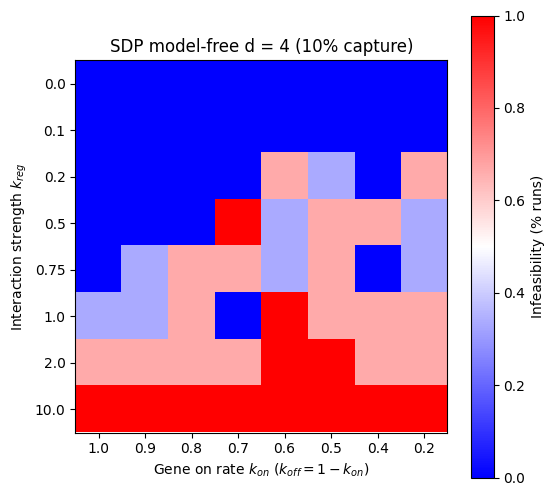

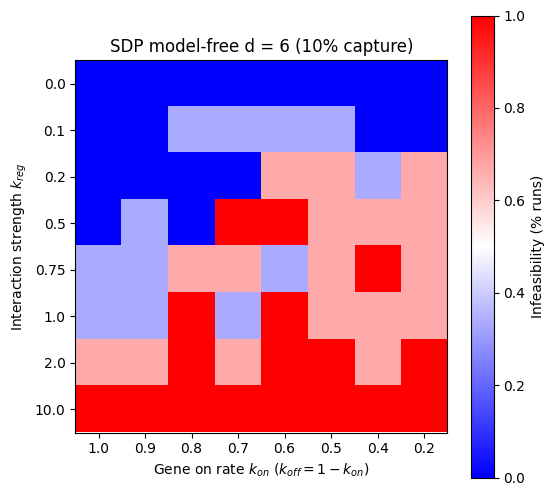

In [145]:
# 10% capture

# d = 2
sdp_10_d2_result = np.load(".\gridtest-results\model-free\sdp\sdp_10_d2.npy")
plot(sdp_10_d2_result, interaction_values, gene_values, "SDP model-free d = 2 (10% capture)", "Infeasibility (% runs)")

# d = 4
sdp_10_d4_result = np.load(".\gridtest-results\model-free\sdp\sdp_10_d4.npy")
plot(sdp_10_d4_result, interaction_values, gene_values, "SDP model-free d = 4 (10% capture)", "Infeasibility (% runs)")

# d = 6
sdp_10_d6_result = np.load(".\gridtest-results\model-free\sdp\sdp_10_d6.npy")
plot(sdp_10_d6_result, interaction_values, gene_values, "SDP model-free d = 6 (10% capture)", "Infeasibility (% runs)")

# Independent Birth Death

## SDP Moments

### Running

In [146]:
import SDP_interaction_inference.optimization
import SDP_interaction_inference.constraints

In [ ]:
d_max = 10
data_100.bootstrap(d_max, tqdm_disable=False)
data_50.bootstrap(d_max, tqdm_disable=False)
data_10.bootstrap(d_max, tqdm_disable=False)

In [147]:
# constraint settings
constraints = SDP_interaction_inference.constraints.Constraint(
    moment_bounds=True,
    moment_matrices=True,
    moment_equations=True,
    factorization=True
)
fixed = [(1, 1), (3, 1)]

100% capture

In [148]:
sdp_100_d2 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_100, d=2, fixed=fixed, constraints=constraints)
sdp_100_d2.analyse_dataset()
sdp_100_d2_result = construct_result_array(sdp_100_d2, interaction_values, gene_values, runs)
np.save(".\gridtest-results\ind-BD\sdp\sdp_100_d2.npy", sdp_100_d2_result)

100%|██████████| 192/192 [00:08<00:00, 23.98it/s]


In [149]:
sdp_100_d4 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_100, d=4, fixed=fixed, constraints=constraints)
sdp_100_d4.analyse_dataset()
sdp_100_d4_result = construct_result_array(sdp_100_d4, interaction_values, gene_values, runs)
np.save(".\gridtest-results\ind-BD\sdp\sdp_100_d4.npy", sdp_100_d4_result)

100%|██████████| 192/192 [00:16<00:00, 11.42it/s]


In [150]:
sdp_100_d6 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_100, d=6, fixed=fixed, constraints=constraints)
sdp_100_d6.analyse_dataset()
sdp_100_d6_result = construct_result_array(sdp_100_d6, interaction_values, gene_values, runs)
np.save(".\gridtest-results\ind-BD\sdp\sdp_100_d6.npy", sdp_100_d6_result)

100%|██████████| 192/192 [00:50<00:00,  3.82it/s]


50% capture

In [151]:
sdp_50_d2 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_50, d=2, fixed=fixed, constraints=constraints)
sdp_50_d2.analyse_dataset()
sdp_50_d2_result = construct_result_array(sdp_50_d2, interaction_values, gene_values, runs)
np.save(".\gridtest-results\ind-BD\sdp\sdp_50_d2.npy", sdp_50_d2_result)

100%|██████████| 192/192 [00:05<00:00, 32.81it/s]


In [152]:
sdp_50_d4 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_50, d=4, fixed=fixed, constraints=constraints)
sdp_50_d4.analyse_dataset()
sdp_50_d4_result = construct_result_array(sdp_50_d4, interaction_values, gene_values, runs)
np.save(".\gridtest-results\ind-BD\sdp\sdp_50_d4.npy", sdp_50_d4_result)

100%|██████████| 192/192 [00:20<00:00,  9.56it/s]


In [154]:
sdp_50_d6 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_50, d=6, fixed=fixed, constraints=constraints)
sdp_50_d6.analyse_dataset()
sdp_50_d6_result = construct_result_array(sdp_50_d6, interaction_values, gene_values, runs)
np.save(".\gridtest-results\ind-BD\sdp\sdp_50_d6.npy", sdp_50_d6_result)

100%|██████████| 192/192 [00:50<00:00,  3.81it/s]


10% capture

In [155]:
sdp_10_d2 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_10, d=2, fixed=fixed, constraints=constraints)
sdp_10_d2.analyse_dataset()
sdp_10_d2_result = construct_result_array(sdp_10_d2, interaction_values, gene_values, runs)
np.save(".\gridtest-results\ind-BD\sdp\sdp_10_d2.npy", sdp_10_d2_result)

100%|██████████| 192/192 [00:06<00:00, 31.61it/s]


In [156]:
sdp_10_d4 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_10, d=4, fixed=fixed, constraints=constraints)
sdp_10_d4.analyse_dataset()
sdp_10_d4_result = construct_result_array(sdp_10_d4, interaction_values, gene_values, runs)
np.save(".\gridtest-results\ind-BD\sdp\sdp_10_d4.npy", sdp_10_d4_result)

100%|██████████| 192/192 [00:24<00:00,  7.68it/s]


In [157]:
sdp_10_d6 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_10, d=6, fixed=fixed, constraints=constraints)
sdp_10_d6.analyse_dataset()
sdp_10_d6_result = construct_result_array(sdp_10_d6, interaction_values, gene_values, runs)
np.save(".\gridtest-results\ind-BD\sdp\sdp_10_d6.npy", sdp_10_d6_result)

100%|██████████| 192/192 [01:27<00:00,  2.20it/s]


### Plots

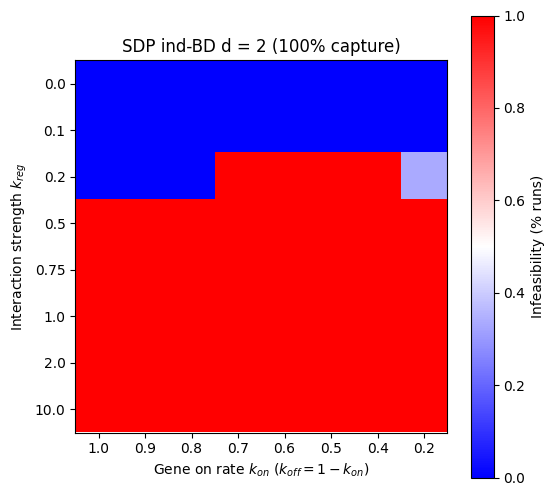

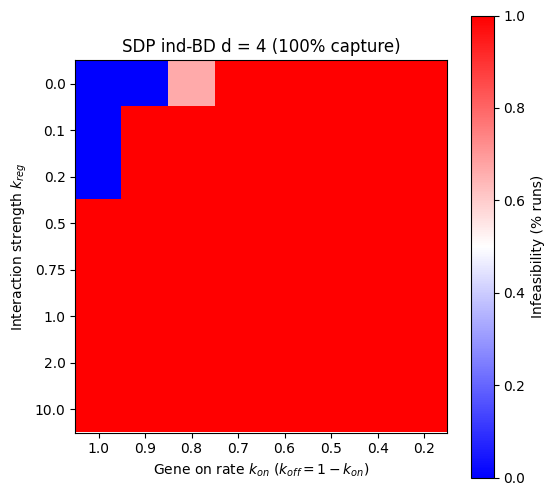

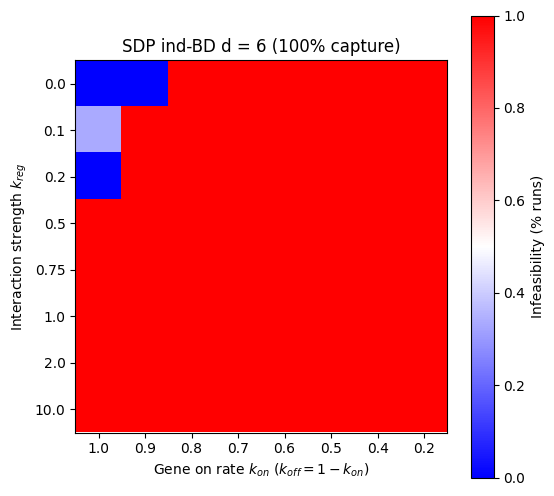

In [158]:
# 100% capture

# d = 2
sdp_100_d2_result = np.load(".\gridtest-results\ind-BD\sdp\sdp_100_d2.npy")
plot(sdp_100_d2_result, interaction_values, gene_values, "SDP ind-BD d = 2 (100% capture)", "Infeasibility (% runs)")

# d = 4
sdp_100_d4_result = np.load(".\gridtest-results\ind-BD\sdp\sdp_100_d4.npy")
plot(sdp_100_d4_result, interaction_values, gene_values, "SDP ind-BD d = 4 (100% capture)", "Infeasibility (% runs)")

# d = 6
sdp_100_d6_result = np.load(".\gridtest-results\ind-BD\sdp\sdp_100_d6.npy")
plot(sdp_100_d6_result, interaction_values, gene_values, "SDP ind-BD d = 6 (100% capture)", "Infeasibility (% runs)")

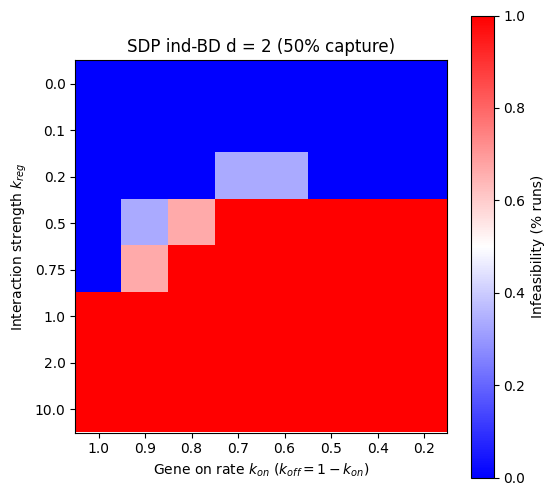

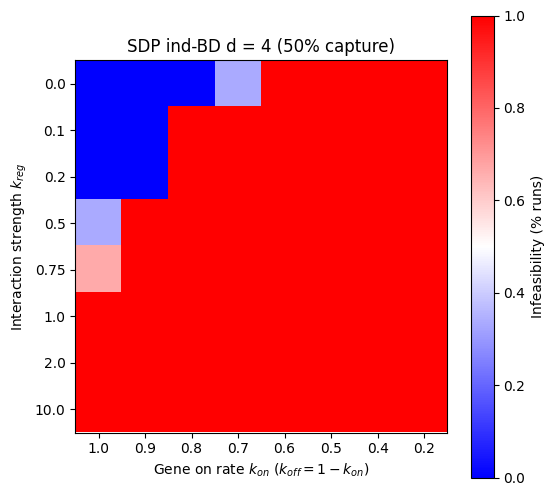

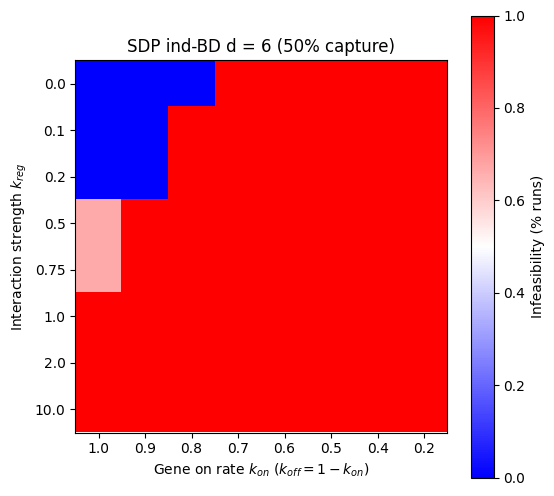

In [159]:
# 50% capture

# d = 2
sdp_50_d2_result = np.load(".\gridtest-results\ind-BD\sdp\sdp_50_d2.npy")
plot(sdp_50_d2_result, interaction_values, gene_values, "SDP ind-BD d = 2 (50% capture)", "Infeasibility (% runs)")

# d = 4
sdp_50_d4_result = np.load(".\gridtest-results\ind-BD\sdp\sdp_50_d4.npy")
plot(sdp_50_d4_result, interaction_values, gene_values, "SDP ind-BD d = 4 (50% capture)", "Infeasibility (% runs)")

# d = 6
sdp_50_d6_result = np.load(".\gridtest-results\ind-BD\sdp\sdp_50_d6.npy")
plot(sdp_50_d6_result, interaction_values, gene_values, "SDP ind-BD d = 6 (50% capture)", "Infeasibility (% runs)")

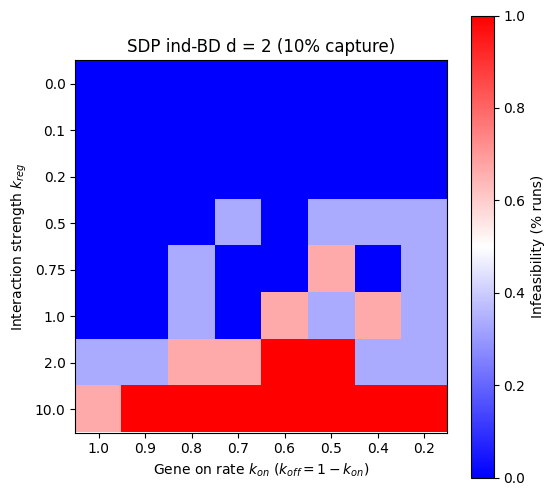

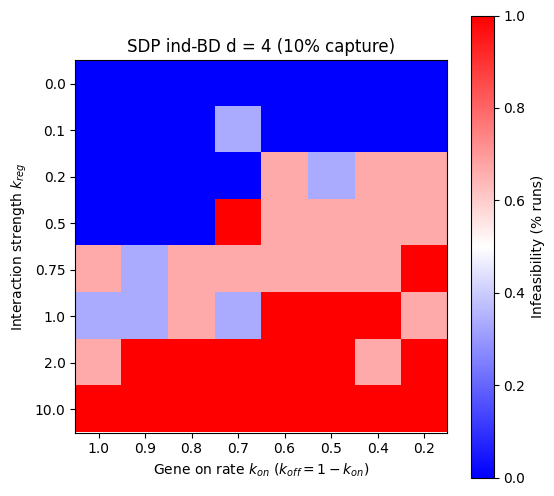

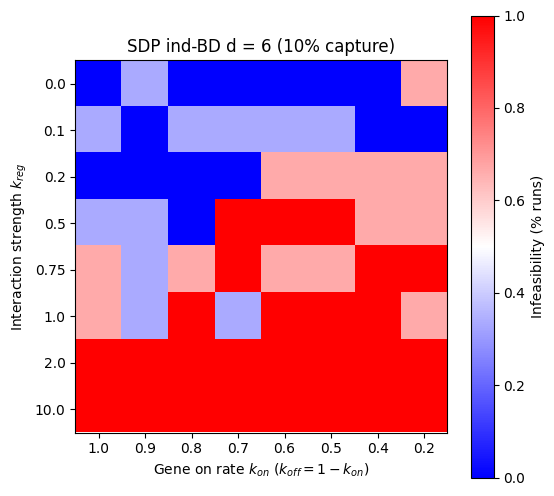

In [160]:
# 10% capture

# d = 2
sdp_10_d2_result = np.load(".\gridtest-results\ind-BD\sdp\sdp_10_d2.npy")
plot(sdp_10_d2_result, interaction_values, gene_values, "SDP ind-BD d = 2 (10% capture)", "Infeasibility (% runs)")

# d = 4
sdp_10_d4_result = np.load(".\gridtest-results\ind-BD\sdp\sdp_10_d4.npy")
plot(sdp_10_d4_result, interaction_values, gene_values, "SDP ind-BD d = 4 (10% capture)", "Infeasibility (% runs)")

# d = 6
sdp_10_d6_result = np.load(".\gridtest-results\ind-BD\sdp\sdp_10_d6.npy")
plot(sdp_10_d6_result, interaction_values, gene_values, "SDP ind-BD d = 6 (10% capture)", "Infeasibility (% runs)")

# Interacting Birth Death

## SDP

### Running

In [ ]:
import SDP_interaction_inference.optimization
import SDP_interaction_inference.constraints

In [ ]:
d_max = 10
data_100.bootstrap(d_max, tqdm_disable=False)
data_50.bootstrap(d_max, tqdm_disable=False)
data_10.bootstrap(d_max, tqdm_disable=False)

100% capture

In [161]:
sdp_100_d2 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_100, d=2)
sdp_100_d2.analyse_dataset()
sdp_100_d2_result = construct_result_array(sdp_100_d2, interaction_values, gene_values, runs)
np.save(".\gridtest-results\int-BD\sdp\sdp_100_d2.npy", sdp_100_d2_result)

100%|██████████| 192/192 [00:08<00:00, 23.00it/s]


In [162]:
sdp_100_d4 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_100, d=4)
sdp_100_d4.analyse_dataset()
sdp_100_d4_result = construct_result_array(sdp_100_d4, interaction_values, gene_values, runs)
np.save(".\gridtest-results\int-BD\sdp\sdp_100_d4.npy", sdp_100_d4_result)

100%|██████████| 192/192 [00:19<00:00,  9.76it/s]


In [163]:
sdp_100_d6 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_100, d=6)
sdp_100_d6.analyse_dataset()
sdp_100_d6_result = construct_result_array(sdp_100_d6, interaction_values, gene_values, runs)
np.save(".\gridtest-results\int-BD\sdp\sdp_100_d6.npy", sdp_100_d6_result)

100%|██████████| 192/192 [01:06<00:00,  2.87it/s]


50% capture

In [164]:
sdp_50_d2 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_50, d=2)
sdp_50_d2.analyse_dataset()
sdp_50_d2_result = construct_result_array(sdp_50_d2, interaction_values, gene_values, runs)
np.save(".\gridtest-results\int-BD\sdp\sdp_50_d2.npy", sdp_50_d2_result)

100%|██████████| 192/192 [00:06<00:00, 30.23it/s]


In [165]:
sdp_50_d4 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_50, d=4)
sdp_50_d4.analyse_dataset()
sdp_50_d4_result = construct_result_array(sdp_50_d4, interaction_values, gene_values, runs)
np.save(".\gridtest-results\int-BD\sdp\sdp_50_d4.npy", sdp_50_d4_result)

100%|██████████| 192/192 [00:19<00:00, 10.03it/s]


In [166]:
sdp_50_d6 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_50, d=6)
sdp_50_d6.analyse_dataset()
sdp_50_d6_result = construct_result_array(sdp_50_d6, interaction_values, gene_values, runs)
np.save(".\gridtest-results\int-BD\sdp\sdp_50_d6.npy", sdp_50_d6_result)

100%|██████████| 192/192 [02:28<00:00,  1.30it/s]


10% capture

In [167]:
sdp_10_d2 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_10, d=2)
sdp_10_d2.analyse_dataset()
sdp_10_d2_result = construct_result_array(sdp_10_d2, interaction_values, gene_values, runs)
np.save(".\gridtest-results\int-BD\sdp\sdp_10_d2.npy", sdp_10_d2_result)

100%|██████████| 192/192 [00:05<00:00, 32.92it/s]


In [168]:
sdp_10_d4 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_10, d=4)
sdp_10_d4.analyse_dataset()
sdp_10_d4_result = construct_result_array(sdp_10_d4, interaction_values, gene_values, runs)
np.save(".\gridtest-results\int-BD\sdp\sdp_10_d4.npy", sdp_10_d4_result)

100%|██████████| 192/192 [00:17<00:00, 10.76it/s]


In [181]:
sdp_10_d6 = SDP_interaction_inference.optimization.BirthDeathOptimization(data_10, d=6)
sdp_10_d6.analyse_dataset()
sdp_10_d6_result = construct_result_array(sdp_10_d6, interaction_values, gene_values, runs)
np.save(".\gridtest-results\int-BD\sdp\sdp_10_d6.npy", sdp_10_d6_result)

  2665   184 infeasible   12               -    0.00000      -  50.9    5s
* 4406   135              15       0.0000000    0.00000  0.00%  51.0    7s

Cutting planes:
  RLT: 54
  BQP: 2

Explored 4546 nodes (231419 simplex iterations) in 7.54 seconds (3.98 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 95 rows, 33 columns and 1004 nonzeros
Model fingerprint: 0x4c6b3a25
Model has 21 quadratic constraints
Variable types: 33 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-09, 1e+00]
  QMatrix r

KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\ipykernel\iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 



Cutting planes:
  RLT: 79
  BQP: 2

Explored 4088 nodes (272271 simplex iterations) in 6.85 seconds (4.94 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 104 rows, 33 columns and 1217 nonzeros
Model fingerprint: 0xdac99a92
Model has 21 quadratic constraints
Variable types: 33 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-09, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-02, 1e+01]

MIP start from previous

KeyboardInterrupt: 

Exception ignored in: 'gurobipy._core.logcallbackstub'
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\ipykernel\iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]
KeyboardInterrupt: 



Cutting planes:
  RLT: 64
  BQP: 1

Explored 2167 nodes (149327 simplex iterations) in 3.32 seconds (2.81 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 115 rows, 33 columns and 1460 nonzeros
Model fingerprint: 0x50c552ae
Model has 21 quadratic constraints
Variable types: 33 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-09, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-02, 1e+01]

MIP start from previous

 51%|█████     | 98/192 [49:48<3:47:17, 145.08s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x01b74fd2
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-02, 8e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 52%|█████▏    | 99/192 [49:51<2:38:51, 102.49s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x0802a65c
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [6e-02, 7e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 52%|█████▏    | 100/192 [49:55<1:51:58, 73.03s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x69b8859d
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-02, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 53%|█████▎    | 101/192 [49:58<1:18:47, 51.95s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x67adecc0
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-02, 4e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 53%|█████▎    | 102/192 [50:00<55:29, 36.99s/it]  

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xd085aa12
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-02, 7e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 54%|█████▎    | 103/192 [50:11<43:25, 29.28s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xb6a53cf5
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 54%|█████▍    | 104/192 [50:14<31:11, 21.27s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x079829ca
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+02]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 55%|█████▍    | 105/192 [51:42<59:47, 41.23s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xcb2f2c9d
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 4e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 55%|█████▌    | 106/192 [51:50<45:08, 31.49s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x0c452a78
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-02, 6e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 56%|█████▌    | 107/192 [51:52<31:46, 22.43s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xcdbb7df4
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-02, 4e+02]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 56%|█████▋    | 108/192 [52:20<33:54, 24.22s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xdaa955de
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 2e+02]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 57%|█████▋    | 109/192 [52:23<24:39, 17.82s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x3f6078d7
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 57%|█████▋    | 110/192 [52:24<17:39, 12.92s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xe11148f9
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 58%|█████▊    | 111/192 [52:26<13:01,  9.65s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x94b4e730
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 58%|█████▊    | 112/192 [52:28<09:24,  7.06s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x27582083
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 976 nonzeros
Presolved model has 59

 59%|█████▉    | 113/192 [52:31<08:03,  6.12s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x16033037
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 59%|█████▉    | 114/192 [52:33<06:07,  4.71s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xb59eadf9
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-03, 6e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 60%|█████▉    | 115/192 [52:34<04:43,  3.69s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xce0c0e5c
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-03, 4e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 60%|██████    | 116/192 [52:36<03:46,  2.98s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x5f33a02c
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 61%|██████    | 117/192 [52:37<03:03,  2.45s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xe30e99a9
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 978 nonzeros
Presolved model has 59

 61%|██████▏   | 118/192 [52:38<02:30,  2.04s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x4e23b474
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-03, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 62%|██████▏   | 119/192 [52:39<02:03,  1.69s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x74e28e43
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-03, 8e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 976 nonzeros
Presolved model has 59

 62%|██████▎   | 120/192 [52:45<03:48,  3.17s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x36a1a113
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 63%|██████▎   | 121/192 [52:52<05:01,  4.25s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xaf664597
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-02, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 64%|██████▎   | 122/192 [52:55<04:23,  3.77s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x18e0204d
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 64%|██████▍   | 123/192 [53:01<05:08,  4.48s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xe1524b3b
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-02, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 65%|██████▍   | 124/192 [53:02<03:58,  3.50s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x9bb4cb27
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-02, 8e+02]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 65%|██████▌   | 125/192 [54:44<36:43, 32.88s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x932afbe2
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-02, 6e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 66%|██████▌   | 126/192 [54:48<26:52, 24.44s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xa52f9514
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-02, 1e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.02s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 66%|██████▌   | 127/192 [54:59<22:11, 20.49s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x9bbe28f2
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 67%|██████▋   | 128/192 [55:02<16:12, 15.19s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xbf71ccfa
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 9e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 67%|██████▋   | 129/192 [55:05<11:53, 11.32s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x4010fada
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 68%|██████▊   | 130/192 [55:15<11:21, 11.00s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x1515037a
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 9e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 68%|██████▊   | 131/192 [55:30<12:32, 12.34s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xd74ecc35
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 7e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 69%|██████▉   | 132/192 [55:37<10:40, 10.67s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x8c1798f7
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [6e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 69%|██████▉   | 133/192 [55:40<08:08,  8.27s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xd13b3f62
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 8e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 70%|██████▉   | 134/192 [55:43<06:26,  6.67s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xf703946a
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [7e-03, 7e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 70%|███████   | 135/192 [55:45<05:05,  5.37s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x0ff620f8
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 71%|███████   | 136/192 [55:50<04:45,  5.10s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xf095d4d1
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-03, 6e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 71%|███████▏  | 137/192 [55:52<04:04,  4.44s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x93b1e349
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 9e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 72%|███████▏  | 138/192 [55:55<03:22,  3.75s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xf389ce65
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 72%|███████▏  | 139/192 [55:57<02:58,  3.37s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x3e6b1405
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.02s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 73%|███████▎  | 140/192 [56:34<11:33, 13.35s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xa25a6ad7
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-03, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 73%|███████▎  | 141/192 [56:45<10:49, 12.74s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x5fca3b8d
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 4e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.01s
Presolved: 291 rows, 90 columns, 919 nonzeros
Presolved model has 59

 74%|███████▍  | 142/192 [56:46<07:47,  9.35s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xc5202b81
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [7e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 74%|███████▍  | 143/192 [56:48<05:48,  7.11s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xee7584eb
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [7e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.01s
Presolved: 291 rows, 90 columns, 919 nonzeros
Presolved model has 59

 75%|███████▌  | 144/192 [56:50<04:26,  5.55s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xfdc36230
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.02s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 76%|███████▌  | 145/192 [56:53<03:39,  4.67s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xce634e87
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 76%|███████▌  | 146/192 [56:57<03:20,  4.37s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x0ee31274
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 77%|███████▋  | 147/192 [56:59<02:48,  3.75s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xdfa96cfe
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 8e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 77%|███████▋  | 148/192 [59:36<36:30, 49.79s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x200fefee
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-02, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 78%|███████▊  | 149/192 [59:38<25:23, 35.43s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xfa4eb37a
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 78%|███████▊  | 150/192 [59:40<17:44, 25.34s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x0e1d2749
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 79%|███████▊  | 151/192 [59:42<12:34, 18.39s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x08c629ce
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 79%|███████▉  | 152/192 [59:44<08:59, 13.50s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x49e2909a
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 80%|███████▉  | 153/192 [59:47<06:47, 10.45s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x031b3236
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-03, 2e+02]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 80%|████████  | 154/192 [59:57<06:31, 10.30s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x9d36c0da
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 81%|████████  | 155/192 [59:59<04:45,  7.72s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x40011790
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-03, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 81%|████████▏ | 156/192 [1:00:33<09:23, 15.64s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xbead7f12
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-03, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 82%|████████▏ | 157/192 [1:00:44<08:13, 14.11s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x18463cf5
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 82%|████████▏ | 158/192 [1:00:48<06:20, 11.19s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x4cdf1786
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [6e-03, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 83%|████████▎ | 159/192 [1:00:50<04:37,  8.39s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xcd96e14f
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-03, 2e+02]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 83%|████████▎ | 160/192 [1:00:52<03:30,  6.58s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x4dec6278
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 84%|████████▍ | 161/192 [1:00:54<02:40,  5.17s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x9003165f
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 84%|████████▍ | 162/192 [1:00:56<02:08,  4.29s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x8c0ce7da
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 85%|████████▍ | 163/192 [1:00:59<01:48,  3.75s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x7ef2bdd0
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 6e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 85%|████████▌ | 164/192 [1:01:01<01:29,  3.20s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x8e2298d6
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [4e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 978 nonzeros
Presolved model has 59

 86%|████████▌ | 165/192 [1:01:03<01:18,  2.89s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x4ee8fd54
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [6e-02, 8e+01]
Presolve removed 40 rows and 19 columns
Presolve time: 0.02s

Barrier solved model in 0 iterations and 0.04 seconds (0.00 work units)
Model is infeasible


 86%|████████▋ | 166/192 [1:01:04<01:00,  2.31s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x3b156008
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 919 nonzeros
Presolved model has 59

 87%|████████▋ | 167/192 [1:01:08<01:12,  2.92s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x76c82f41
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-03, 2e+02]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 972 nonzeros
Presolved model has 59

 88%|████████▊ | 168/192 [1:01:10<01:00,  2.51s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xb3517962
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-03, 5e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.01s
Presolved: 301 rows, 90 columns, 976 nonzeros
Presolved model has 59

Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\SDP_interaction_inference\optimization.py", line 114, in analyse_dataset
    solution_dict[i] = self.feasibility_test(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\SDP_interaction_inference\optimization.py", line 307, in feasibility_test
    model, semidefinite_feas = optimization_utils.semidefinite_cut(self, model, variables)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\SDP_interaction_inference\optimization_utils.py", line 396, in semidefinite_cut
    {f'M_val': variables[f'M_{s}'].X}
  File "src\\gurobipy\\mvar.pxi", line 306, in gurobipy._matrixapi.MVar.__getattr__
  File "src\\gurobipy\\mvar.pxi", line 607, in gurobipy._matrixapi.MVar.getAttr
  File "src\\gurobipy\\_attrutil.pyx", line 165, in gurobipy._attrutil._gettypedattrlist
gurobipy._exception.GurobiError: Unable to retrieve attribute 'X'
 88%|████████▊ | 169/19

Optimization failed: Unable to retrieve attribute 'X'
Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xfe319d80
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-03, 5e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301

 89%|████████▊ | 170/192 [1:06:14<23:55, 65.24s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x1917d59b
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-03, 6e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 972 nonzeros
Presolved model has 59

 89%|████████▉ | 171/192 [1:06:26<17:16, 49.37s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xa54b80d4
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-03, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 90%|████████▉ | 172/192 [1:06:27<11:37, 34.89s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x10a0b66e
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-03, 1e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 90%|█████████ | 173/192 [1:06:29<07:50, 24.74s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xc5b4850e
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-03, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 91%|█████████ | 174/192 [1:06:30<05:17, 17.61s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x571c3ac6
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-03, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 91%|█████████ | 175/192 [1:06:31<03:35, 12.68s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x60efe426
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 92%|█████████▏| 176/192 [1:06:32<02:27,  9.23s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x86502686
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 92%|█████████▏| 177/192 [1:06:33<01:41,  6.76s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x0325cb0b
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-03, 6e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.01s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 93%|█████████▎| 178/192 [1:06:34<01:10,  5.04s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x8b5592e7
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 93%|█████████▎| 179/192 [1:06:35<00:50,  3.90s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x5a2bedfb
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-03, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 94%|█████████▍| 180/192 [1:06:58<01:55,  9.61s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x1d713ba7
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-03, 3e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.01s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 94%|█████████▍| 181/192 [1:06:59<01:17,  7.01s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x108b344d
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [2e-03, 6e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 12 rows and 2 columns
Presolve time: 0.00s
Presolved: 301 rows, 90 columns, 982 nonzeros
Presolved model has 59

 95%|█████████▍| 182/192 [1:07:00<00:52,  5.28s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x914ba900
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-03, 1e+02]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 95%|█████████▌| 183/192 [1:07:02<00:37,  4.20s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x34ff6920
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [1e-02, 8e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 96%|█████████▌| 184/192 [1:07:03<00:25,  3.24s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x1ce7e4f6
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [6e-03, 6e+00]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 96%|█████████▋| 185/192 [1:07:04<00:18,  2.65s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x9ab67ae7
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [9e-02, 1e+02]
Presolve removed 40 rows and 19 columns
Presolve time: 0.02s

Barrier solved model in 0 iterations and 0.02 seconds (0.00 work units)
Model is infeasible


 97%|█████████▋| 186/192 [1:07:05<00:12,  2.09s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xff991dc9
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-02, 2e+01]
Presolve removed 40 rows and 19 columns
Presolve time: 0.02s

Barrier solved model in 0 iterations and 0.03 seconds (0.00 work units)
Model is infeasible


 97%|█████████▋| 187/192 [1:07:06<00:08,  1.70s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x28b32d24
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-03, 2e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 929 nonzeros
Presolved model has 59

 98%|█████████▊| 188/192 [1:07:07<00:06,  1.58s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x1aa73c7f
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [3e-03, 9e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 923 nonzeros
Presolved model has 59

 98%|█████████▊| 189/192 [1:07:08<00:04,  1.46s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x05a4d968
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-02, 3e+01]
Presolve removed 40 rows and 19 columns
Presolve time: 0.01s

Barrier solved model in 0 iterations and 0.02 seconds (0.00 work units)
Model is infeasible


 99%|█████████▉| 190/192 [1:07:09<00:02,  1.19s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0xbf8051d8
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-03, 5e+01]
Presolve removed 34 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 22 rows and 2 columns
Presolve time: 0.00s
Presolved: 291 rows, 90 columns, 919 nonzeros
Presolved model has 59

 99%|█████████▉| 191/192 [1:07:10<00:01,  1.11s/it]

Set parameter Username
Set parameter LicenseID to value 2616229
Academic license - for non-commercial use only - expires 2026-01-29
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  300

Optimize a model with 58 rows, 33 columns and 228 nonzeros
Model fingerprint: 0x63d736f0
Model has 21 quadratic constraints
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [5e-02, 6e+01]
Presolve removed 40 rows and 19 columns
Presolve time: 0.02s

Barrier solved model in 0 iterations and 0.02 seconds (0.00 work units)
Model is infeasible


100%|██████████| 192/192 [1:07:10<00:00, 20.99s/it]


### Plots

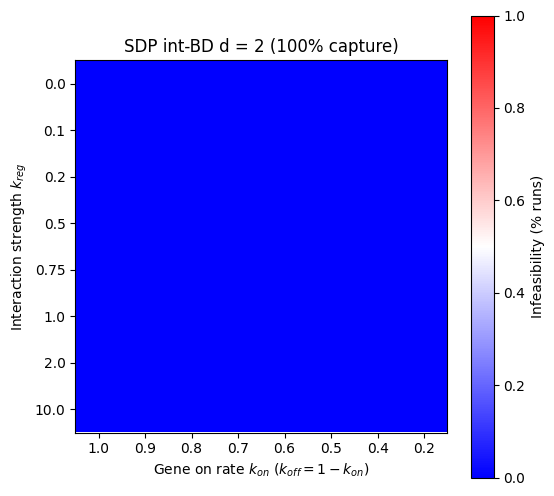

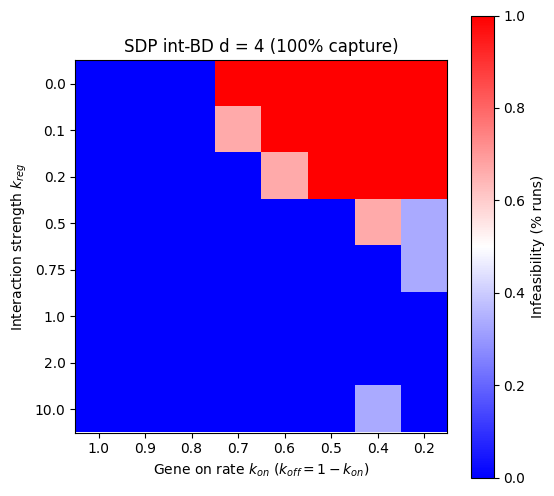

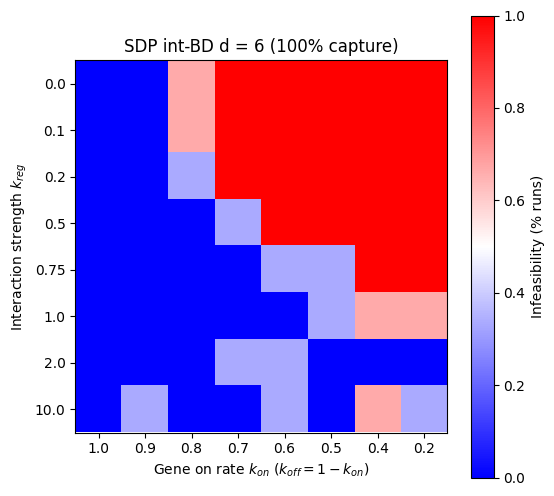

In [170]:
# 100% capture

# d = 2
sdp_100_d2_result = np.load(".\gridtest-results\int-BD\sdp\sdp_100_d2.npy")
plot(sdp_100_d2_result, interaction_values, gene_values, "SDP int-BD d = 2 (100% capture)", "Infeasibility (% runs)")

# d = 4
sdp_100_d4_result = np.load(".\gridtest-results\int-BD\sdp\sdp_100_d4.npy")
plot(sdp_100_d4_result, interaction_values, gene_values, "SDP int-BD d = 4 (100% capture)", "Infeasibility (% runs)")

# d = 6
sdp_100_d6_result = np.load(".\gridtest-results\int-BD\sdp\sdp_100_d6.npy")
plot(sdp_100_d6_result, interaction_values, gene_values, "SDP int-BD d = 6 (100% capture)", "Infeasibility (% runs)")

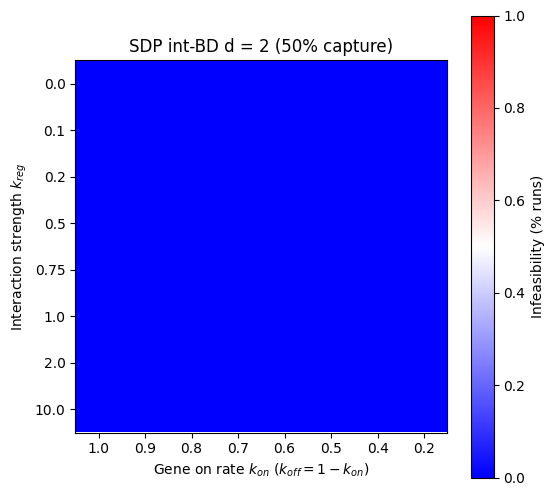

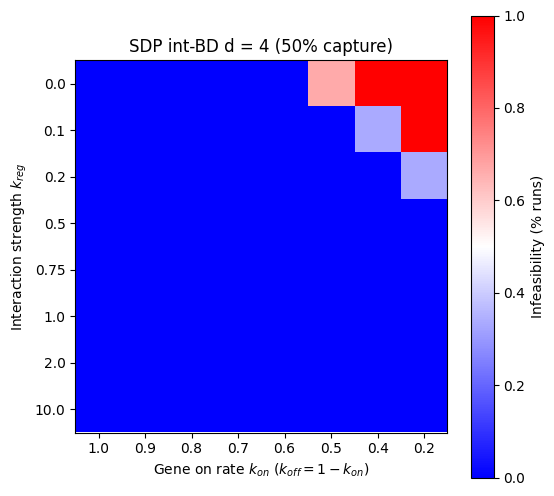

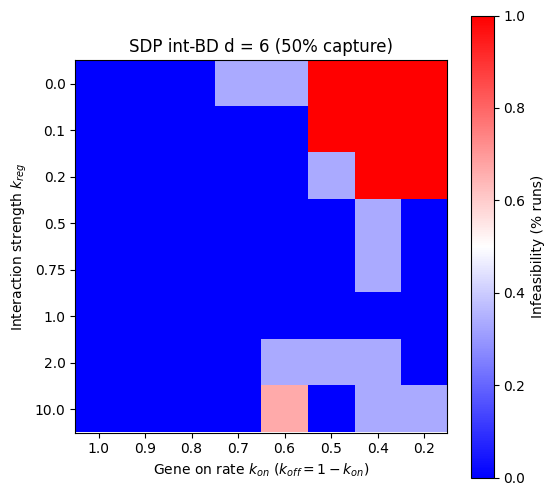

In [171]:
# 50% capture

# d = 2
sdp_50_d2_result = np.load(".\gridtest-results\int-BD\sdp\sdp_50_d2.npy")
plot(sdp_50_d2_result, interaction_values, gene_values, "SDP int-BD d = 2 (50% capture)", "Infeasibility (% runs)")

# d = 4
sdp_50_d4_result = np.load(".\gridtest-results\int-BD\sdp\sdp_50_d4.npy")
plot(sdp_50_d4_result, interaction_values, gene_values, "SDP int-BD d = 4 (50% capture)", "Infeasibility (% runs)")

# d = 6
sdp_50_d6_result = np.load(".\gridtest-results\int-BD\sdp\sdp_50_d6.npy")
plot(sdp_50_d6_result, interaction_values, gene_values, "SDP int-BD d = 6 (50% capture)", "Infeasibility (% runs)")

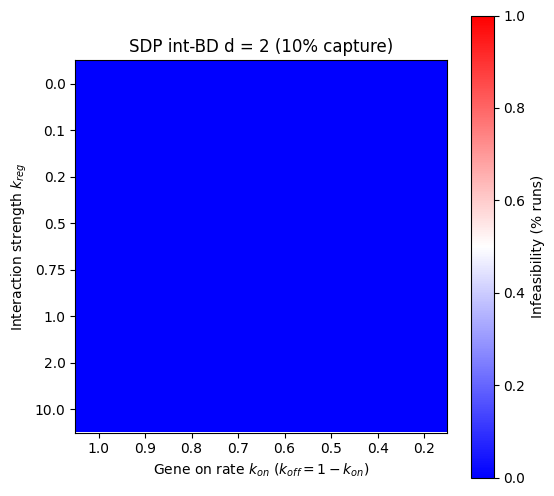

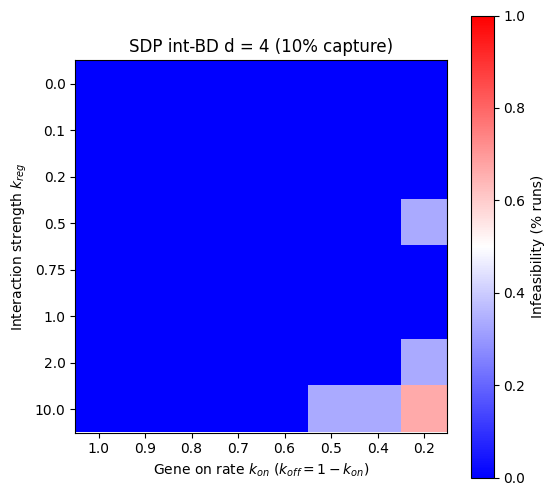

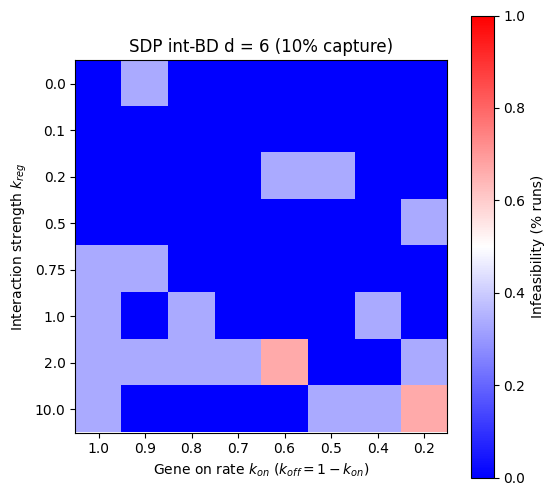

In [183]:
# 10% capture

# d = 2
sdp_10_d2_result = np.load(".\gridtest-results\int-BD\sdp\sdp_10_d2.npy")
plot(sdp_10_d2_result, interaction_values, gene_values, "SDP int-BD d = 2 (10% capture)", "Infeasibility (% runs)")

# d = 4
sdp_10_d4_result = np.load(".\gridtest-results\int-BD\sdp\sdp_10_d4.npy")
plot(sdp_10_d4_result, interaction_values, gene_values, "SDP int-BD d = 4 (10% capture)", "Infeasibility (% runs)")

# d = 6
sdp_10_d6_result = np.load(".\gridtest-results\int-BD\sdp\sdp_10_d6.npy")
plot(sdp_10_d6_result, interaction_values, gene_values, "SDP int-BD d = 6 (10% capture)", "Infeasibility (% runs)")

# Independent Telegraph

# Interacting Telegraph

# Parameter selection

In previous gridtests used parameters:

```{python}
gene_values = [1.0, 0.9, 0.8, 0.6, 0.4, 0.2]
interaction_values = [0, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]
rate = 5
```

However, this leads to samples with very low mean expression, especially when applying capture efficiency, which is not a realistic scenario. So adjust parameters (increase transcription rate) to ensure mean expression remains high. But also need to ensure regulation strength is adjusted to be in a range from easily detected to not: check using correlation test that this is the case.

In [19]:
int_val = 10
gene_val = 0.1
rate = 10

# Set reaction rate parameters
params = {
    'k_on_1': gene_val,
    'k_on_2': gene_val,
    'k_off_1': 1 - gene_val,
    'k_off_2': 1 - gene_val,
    'k_tx_1': rate,
    'k_tx_2': rate,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': int_val
}

# simulate sample from model
sample = SDP_interaction_inference.simulation.gillespie_telegraph(params, 1000)

In [20]:
np.mean(sample, axis=0)

array([0.853, 0.85 ])

In [81]:
# parameters
interaction_values = [10.0, 5.0, 2.0, 1.0, 0.75, 0.5, 0.2, 0.1, 0]
gene_values = [1.0, 0.9, 0.8, 0.6, 0.4, 0.2]
rate = 10
runs = 1
cells = 1000
tqdm_disable = False

# number of pairs
gene_pairs = len(interaction_values) * len(gene_values) * runs

# dataframes
params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

# sample counter
i = 0

# for each sample
for int_val in tqdm.tqdm(interaction_values, disable=tqdm_disable):
    for gene_val in gene_values:
        for k in range(runs):

            # Set reaction rate parameters
            k_on_1 = gene_val
            k_on_2 = gene_val
            k_off_1 = 1 - gene_val
            k_off_2 = 1 - gene_val
            k_tx_1 = rate
            k_tx_2 = rate
            k_deg_1 = 1
            k_deg_2 = 1
            k_reg = int_val

            # store parameters
            params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

            params = {
                'k_on_1': k_on_1,
                'k_on_2': k_on_2,
                'k_off_1': k_off_1,
                'k_off_2': k_off_2,
                'k_tx_1': k_tx_1,
                'k_tx_2': k_tx_2,
                'k_deg_1': k_deg_1,
                'k_deg_2': k_deg_2,
                'k_reg': k_reg
            }

            # simulate sample from model
            sample = SDP_interaction_inference.simulation.gillespie_telegraph(params, cells)

            # store counts
            counts_df.iloc[i] = sample

            # increment sample
            i += 1

100%|██████████| 9/9 [04:47<00:00, 31.92s/it]


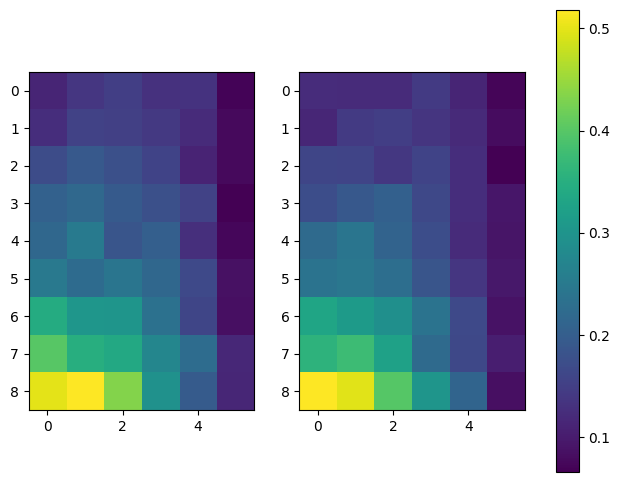

In [64]:
# mean arrays
means_x1 = np.zeros((len(interaction_values), len(gene_values)))
means_x2 = np.zeros((len(interaction_values), len(gene_values)))

# capture
m = 0.1
b = (1 / m) - 1
if b == 0:
    beta = np.ones(cells)
else:
    beta = rng.beta(1, b, size=cells)

# sample counter
i = 0

# for each sample
for j, int_val in enumerate(interaction_values):
    for k, gene_val in enumerate(gene_values):
        sample = np.array(counts_df.iloc[i].to_list())
        sample_x1 = sample[:, 0]
        sample_x2 = sample[:, 1]
        downsample_x1 = rng.binomial(sample_x1, beta)
        downsample_x2 = rng.binomial(sample_x2, beta)
        m1 = downsample_x1.mean()
        m2 = downsample_x2.mean()
        means_x1[j, k] = m1
        means_x2[j, k] = m2
        i += 1

# display
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
img1 = axs[0].imshow(means_x1)
img2 = axs[1].imshow(means_x2)
cbar = plt.colorbar(img2, ax=axs)
plt.show()

In [65]:
means_x2

array([[0.124, 0.121, 0.122, 0.143, 0.113, 0.072],
       [0.115, 0.142, 0.149, 0.136, 0.12 , 0.081],
       [0.16 , 0.158, 0.14 , 0.157, 0.126, 0.066],
       [0.173, 0.191, 0.205, 0.164, 0.126, 0.094],
       [0.223, 0.242, 0.21 , 0.172, 0.121, 0.092],
       [0.238, 0.246, 0.23 , 0.186, 0.137, 0.096],
       [0.332, 0.312, 0.292, 0.238, 0.165, 0.088],
       [0.358, 0.376, 0.324, 0.222, 0.164, 0.104],
       [0.518, 0.497, 0.399, 0.301, 0.211, 0.084]])

## Effect of mean

Does a higher mean expression matter?

In [67]:
import SDP_interaction_inference.correlation

In [80]:
# settings
rate = 10
int_val = 1
m = 0.5
b = (1 / m) - 1
cells = 1000

# parameters
params = {
    'k_tx_1': rate,
    'k_tx_2': rate,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': int_val
}

# simulate
data = SDP_interaction_inference.simulation.simulate_dataset_range_BD([int_val], cells, rate)

# downsample
if b == 0:
    beta = np.ones(cells)
else:
    beta = rng.beta(1, b, size=cells)
data = data.downsample(beta)

# correlation test
corr = SDP_interaction_inference.correlation.Correlation(data)

100%|██████████| 1/1 [00:00<00:00, 397.34it/s]

sample 0 p-value: 0.9803687103288412
